In [4]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data1
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle as pkl

nc = 1
nz = 100
num_epochs=500
batch_size=128
lr = 0.002
ngpu = 1
beta1=0.5

In [2]:
data=pkl.load(open('data/X_processed.pkl', 'rb'))
data=np.expand_dims(data, axis=1)
data=torch.from_numpy(data).float()
class MyDataset(data1.Dataset):
    def __init__(self, data):
        
        self.data = data

    def __getitem__(self, index):
       
        return self.data[index],index

    def __len__(self):
        return len(self.data)    

dataloader = torch.utils.data.DataLoader(dataset=MyDataset(data),batch_size=batch_size,
                                         shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, 128, (3,1), 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 128, 64, 2 , 2, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1): netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, (6,2), 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), pad

In [25]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        for _ in range(1):
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.ones(b_size,).to(device)
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()


            noise = torch.randn(b_size, nz, 1, 1, device=device)

            fake = netG(noise)
            label.fill_(fake_label)

            output = netD(fake.detach()).view(-1)

            errD_fake = criterion(output, label)

            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake

            optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())


torch.save(netG, 'data\parameter.pkl')


Random Seed:  999
Starting Training Loop...
[0][0/25]	Loss_D: 1.5099	Loss_G: 1.6552	D(x): 0.4646	D(G(z)): 0.5196 / 0.1951
[1][0/25]	Loss_D: 0.8167	Loss_G: 2.0718	D(x): 0.8838	D(G(z)): 0.4946 / 0.1570
[2][0/25]	Loss_D: 0.8650	Loss_G: 1.2882	D(x): 0.5995	D(G(z)): 0.2873 / 0.2842
[3][0/25]	Loss_D: 0.8710	Loss_G: 1.8748	D(x): 0.7261	D(G(z)): 0.4191 / 0.1553
[4][0/25]	Loss_D: 0.7942	Loss_G: 2.1339	D(x): 0.9206	D(G(z)): 0.4998 / 0.1308
[5][0/25]	Loss_D: 0.2659	Loss_G: 2.2562	D(x): 0.9070	D(G(z)): 0.1416 / 0.1162
[6][0/25]	Loss_D: 0.0821	Loss_G: 3.3311	D(x): 0.9684	D(G(z)): 0.0478 / 0.0391
[7][0/25]	Loss_D: 0.9811	Loss_G: 1.1020	D(x): 0.5910	D(G(z)): 0.3529 / 0.3403
[8][0/25]	Loss_D: 0.6558	Loss_G: 2.4198	D(x): 0.8166	D(G(z)): 0.3602 / 0.0926
[9][0/25]	Loss_D: 0.1217	Loss_G: 3.2677	D(x): 0.9422	D(G(z)): 0.0596 / 0.0420
[10][0/25]	Loss_D: 0.0617	Loss_G: 3.8796	D(x): 0.9750	D(G(z)): 0.0356 / 0.0216
[11][0/25]	Loss_D: 0.0556	Loss_G: 4.0073	D(x): 0.9863	D(G(z)): 0.0406 / 0.0217
[12][0/25]	Loss_D:

[104][0/25]	Loss_D: 1.3841	Loss_G: 0.7603	D(x): 0.5050	D(G(z)): 0.5017 / 0.4682
[105][0/25]	Loss_D: 1.4072	Loss_G: 0.6691	D(x): 0.4731	D(G(z)): 0.4700 / 0.5150
[106][0/25]	Loss_D: 1.4038	Loss_G: 0.6957	D(x): 0.4554	D(G(z)): 0.4568 / 0.5008
[107][0/25]	Loss_D: 1.2810	Loss_G: 0.7581	D(x): 0.4962	D(G(z)): 0.4160 / 0.4737
[108][0/25]	Loss_D: 1.9419	Loss_G: 0.2543	D(x): 0.1763	D(G(z)): 0.1694 / 0.7770
[109][0/25]	Loss_D: 1.3714	Loss_G: 0.7571	D(x): 0.5049	D(G(z)): 0.4934 / 0.4714
[110][0/25]	Loss_D: 1.4102	Loss_G: 0.7008	D(x): 0.5139	D(G(z)): 0.5201 / 0.4989
[111][0/25]	Loss_D: 1.3476	Loss_G: 0.6550	D(x): 0.4734	D(G(z)): 0.4472 / 0.5207
[112][0/25]	Loss_D: 1.4264	Loss_G: 0.9508	D(x): 0.5795	D(G(z)): 0.5837 / 0.3874
[113][0/25]	Loss_D: 1.3785	Loss_G: 0.6387	D(x): 0.4404	D(G(z)): 0.4245 / 0.5291
[114][0/25]	Loss_D: 1.3697	Loss_G: 0.7212	D(x): 0.5053	D(G(z)): 0.4935 / 0.4889
[115][0/25]	Loss_D: 1.4379	Loss_G: 1.0787	D(x): 0.6150	D(G(z)): 0.6101 / 0.3412
[116][0/25]	Loss_D: 1.3919	Loss_G: 0.705

[309][0/25]	Loss_D: 1.2218	Loss_G: 1.4122	D(x): 0.7104	D(G(z)): 0.5615 / 0.2686
[310][0/25]	Loss_D: 1.3629	Loss_G: 1.6944	D(x): 0.7791	D(G(z)): 0.6384 / 0.2148
[311][0/25]	Loss_D: 1.1666	Loss_G: 1.6101	D(x): 0.6630	D(G(z)): 0.4789 / 0.2265
[312][0/25]	Loss_D: 1.1896	Loss_G: 1.5373	D(x): 0.6234	D(G(z)): 0.4737 / 0.2508
[313][0/25]	Loss_D: 1.1154	Loss_G: 1.0101	D(x): 0.5572	D(G(z)): 0.3673 / 0.4067
[314][0/25]	Loss_D: 1.1639	Loss_G: 1.3354	D(x): 0.5386	D(G(z)): 0.3403 / 0.3047
[315][0/25]	Loss_D: 1.2064	Loss_G: 0.8615	D(x): 0.4607	D(G(z)): 0.2846 / 0.4540
[316][0/25]	Loss_D: 1.1586	Loss_G: 0.9419	D(x): 0.5267	D(G(z)): 0.3552 / 0.4239
[317][0/25]	Loss_D: 1.0905	Loss_G: 1.2811	D(x): 0.6700	D(G(z)): 0.4594 / 0.3226
[318][0/25]	Loss_D: 1.0845	Loss_G: 1.3627	D(x): 0.7266	D(G(z)): 0.5031 / 0.2786
[319][0/25]	Loss_D: 1.3043	Loss_G: 1.8348	D(x): 0.7432	D(G(z)): 0.5927 / 0.1902
[320][0/25]	Loss_D: 1.1628	Loss_G: 1.3361	D(x): 0.7046	D(G(z)): 0.5209 / 0.2934
[321][0/25]	Loss_D: 0.9205	Loss_G: 1.067

[412][0/25]	Loss_D: 1.1398	Loss_G: 1.4693	D(x): 0.6131	D(G(z)): 0.4173 / 0.2864
[413][0/25]	Loss_D: 0.9511	Loss_G: 1.4525	D(x): 0.7226	D(G(z)): 0.4340 / 0.2637
[414][0/25]	Loss_D: 1.0518	Loss_G: 1.3762	D(x): 0.6700	D(G(z)): 0.4262 / 0.3177
[415][0/25]	Loss_D: 1.1368	Loss_G: 0.9050	D(x): 0.5203	D(G(z)): 0.3292 / 0.4484
[416][0/25]	Loss_D: 1.1193	Loss_G: 1.2924	D(x): 0.5654	D(G(z)): 0.3683 / 0.3228
[417][0/25]	Loss_D: 1.3099	Loss_G: 0.6609	D(x): 0.4822	D(G(z)): 0.3394 / 0.5571
[418][0/25]	Loss_D: 1.1393	Loss_G: 1.1404	D(x): 0.5157	D(G(z)): 0.3118 / 0.3829
[419][0/25]	Loss_D: 0.9820	Loss_G: 1.2168	D(x): 0.6234	D(G(z)): 0.3602 / 0.3483
[420][0/25]	Loss_D: 1.2701	Loss_G: 1.6130	D(x): 0.6690	D(G(z)): 0.5382 / 0.2420
[421][0/25]	Loss_D: 1.1068	Loss_G: 1.5614	D(x): 0.6960	D(G(z)): 0.4838 / 0.2519
[422][0/25]	Loss_D: 1.2071	Loss_G: 0.9951	D(x): 0.5322	D(G(z)): 0.3563 / 0.4288
[423][0/25]	Loss_D: 1.1644	Loss_G: 1.7416	D(x): 0.7112	D(G(z)): 0.5341 / 0.1980
[424][0/25]	Loss_D: 0.8292	Loss_G: 1.562

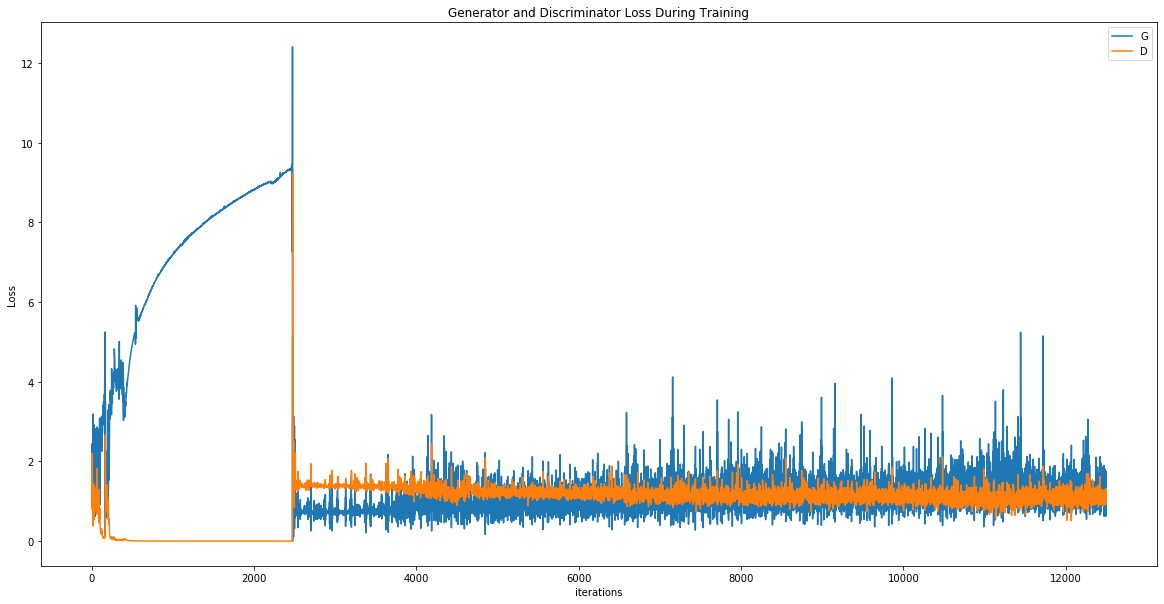

In [26]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)
save_path = 'data\parameter.pkl'
netG=torch.load(save_path)
z = torch.randn(100,100, 1, 1, device=device)
fake = netG(z).detach().cpu()
fake=fake.reshape(-1,8)
print(fake[:30])
np.savetxt('fake.csv',fake,delimiter=',')

tensor([[0.0516, 0.1373, 0.1075, 0.1092, 0.2002, 0.0504, 0.7035, 0.0927],
        [0.0571, 0.1271, 0.1272, 0.0878, 0.2185, 0.0378, 0.7127, 0.0767],
        [0.0350, 0.1501, 0.1157, 0.1066, 0.2156, 0.0523, 0.7325, 0.0885],
        [0.0447, 0.1300, 0.1348, 0.0991, 0.2315, 0.0400, 0.6306, 0.0834],
        [0.0449, 0.1446, 0.1222, 0.1177, 0.2342, 0.0467, 0.6218, 0.0911],
        [0.0520, 0.1370, 0.1370, 0.1086, 0.2239, 0.0323, 0.6577, 0.0821],
        [0.0337, 0.1627, 0.1320, 0.1173, 0.1671, 0.0468, 0.6911, 0.0925],
        [0.0391, 0.1548, 0.1479, 0.1046, 0.2149, 0.0418, 0.7262, 0.0839],
        [0.0315, 0.1727, 0.1316, 0.1083, 0.1697, 0.0423, 0.7043, 0.0943],
        [0.0642, 0.1585, 0.1374, 0.0961, 0.1712, 0.0306, 0.7099, 0.0814],
        [0.0351, 0.1765, 0.1328, 0.1073, 0.1710, 0.0435, 0.6886, 0.0908],
        [0.0433, 0.1580, 0.1535, 0.1086, 0.1895, 0.0294, 0.6006, 0.0840],
        [0.0394, 0.1713, 0.1406, 0.1292, 0.2003, 0.0404, 0.5840, 0.0916],
        [0.0470, 0.1548, 0.1526, 0.126